<h1><center>Comparison of Supervised Models to Predict AQI</center></h1>

<h3><center>Rishi Bhuptani, Mounica Bachu, Akshata Sheshagiri</center></h3>

$\rule{25cm}{0.4pt}$

<h2><center>Imports

In [1]:
#finding spark
import findspark
findspark.init()

In [2]:
##For actual code
from itertools import chain
import pyspark.mllib.stat as st

##sql imports
from pyspark.sql import *
import pyspark.sql.types as typ
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as fn

##for date functions
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date

## for file loading
import os

##For Setting Seed
import random

In [3]:
#Start Spark
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

<h2><center>Creating Schemas

In [4]:
labels_temp= [('State_Code',typ.IntegerType()),
          ('County_Code',typ.IntegerType()),
         ('Site_Num',typ.IntegerType()),
         ('Parameter_Code',typ.IntegerType()),
         ('POC',typ.IntegerType()),
         ('Latitude',typ.FloatType()),
         ('Longitude',typ.FloatType()),
         ('Datum',typ.StringType()),
         ('Parameter_Name',typ.StringType()),
         ('Sample_Duration',typ.StringType()),
         ('Pollutant_Standard',typ.StringType()),
         ('Date_Local',typ.StringType()),
          ('Units_of_Measure',typ.StringType()),
          ('Event_Type',typ.StringType()),
         ('Observation_Count',typ.IntegerType()),
         ('Observation_Percent',typ.IntegerType()),
         ('temp_Mean',typ.FloatType()),
         ('temp_1st_Max_Value',typ.FloatType()),
         ('temp_1st_Max_Hour',typ.FloatType()),
         ('AQI',typ.IntegerType()),
         ('Method_Code',typ.IntegerType()),
         ('Method_Name',typ.StringType()),
         ('Local_Site_Name',typ.StringType()),
         ('Address',typ.StringType()),
          ('State_Name',typ.StringType()),
          ('County_Name',typ.StringType()),
         ('City_Name',typ.StringType()),
         ('CBSA_Name',typ.StringType()),
         ('Date_of_Last_Change',typ.StringType())
         ]


schema_temp = typ.StructType([
typ.StructField(e[0], e[1], False) for e in labels_temp
])

In [5]:
labels_wind= [('State_Code',typ.IntegerType()),
          ('County_Code',typ.IntegerType()),
         ('Site_Num',typ.IntegerType()),
         ('Parameter_Code',typ.IntegerType()),
         ('POC',typ.IntegerType()),
         ('Latitude',typ.FloatType()),
         ('Longitude',typ.FloatType()),
         ('Datum',typ.StringType()),
         ('Parameter_Name',typ.StringType()),
         ('Sample_Duration',typ.StringType()),
         ('Pollutant_Standard',typ.StringType()),
         ('Date_Local',typ.StringType()),
          ('Units_of_Measure',typ.StringType()),
          ('Event_Type',typ.StringType()),
         ('Observation_Count',typ.IntegerType()),
         ('Observation_Percent',typ.IntegerType()),
         ('wind_Mean',typ.FloatType()),
         ('wind_1st_Max_Value',typ.FloatType()),
         ('wind_1st_Max_Hour',typ.FloatType()),
         ('AQI',typ.IntegerType()),
         ('Method_Code',typ.IntegerType()),
         ('Method_Name',typ.StringType()),
         ('Local_Site_Name',typ.StringType()),
         ('Address',typ.StringType()),
          ('State_Name',typ.StringType()),
          ('County_Name',typ.StringType()),
         ('City_Name',typ.StringType()),
         ('CBSA_Name',typ.StringType()),
         ('Date_of_Last_Change',typ.StringType())
         ]


schema_wind = typ.StructType([
typ.StructField(e[0], e[1], False) for e in labels_wind
])

In [6]:
labels_pressure= [('State_Code',typ.IntegerType()),
          ('County_Code',typ.IntegerType()),
         ('Site_Num',typ.IntegerType()),
         ('Parameter_Code',typ.IntegerType()),
         ('POC',typ.IntegerType()),
         ('Latitude',typ.FloatType()),
         ('Longitude',typ.FloatType()),
         ('Datum',typ.StringType()),
         ('Parameter_Name',typ.StringType()),
         ('Sample_Duration',typ.StringType()),
         ('Pollutant_Standard',typ.StringType()),
         ('Date_Local',typ.StringType()),
          ('Units_of_Measure',typ.StringType()),
          ('Event_Type',typ.StringType()),
         ('Observation_Count',typ.IntegerType()),
         ('Observation_Percent',typ.IntegerType()),
         ('pressure_Mean',typ.FloatType()),
         ('pressure_1st_Max_Value',typ.FloatType()),
         ('pressure_1st_Max_Hour',typ.FloatType()),
         ('AQI',typ.IntegerType()),
         ('Method_Code',typ.IntegerType()),
         ('Method_Name',typ.StringType()),
         ('Local_Site_Name',typ.StringType()),
         ('Address',typ.StringType()),
          ('State_Name',typ.StringType()),
          ('County_Name',typ.StringType()),
         ('City_Name',typ.StringType()),
         ('CBSA_Name',typ.StringType()),
         ('Date_of_Last_Change',typ.StringType())
         ]


schema_pressure = typ.StructType([
typ.StructField(e[0], e[1], False) for e in labels_pressure
])

In [7]:
labels = [('State_Code',typ.IntegerType()),
          ('County_Code',typ.IntegerType()),
         ('Site_Num',typ.IntegerType()),
         ('Parameter_Code',typ.IntegerType()),
         ('POC',typ.IntegerType()),
         ('Latitude',typ.FloatType()),
         ('Longitude',typ.FloatType()),
         ('Datum',typ.StringType()),
         ('Parameter_Name',typ.StringType()),
         ('Sample_Duration',typ.StringType()),
         ('Pollutant_Standard',typ.StringType()),
         ('Date_Local',typ.StringType()),
          ('Units_of_Measure',typ.StringType()),
          ('Event_Type',typ.StringType()),
         ('Observation_Count',typ.IntegerType()),
         ('Observation_Percent',typ.IntegerType()),
         ('Mean',typ.FloatType()),
         ('1st_Max_Value',typ.FloatType()),
         ('1st_Max_Hour',typ.FloatType()),
         ('AQI',typ.IntegerType()),
         ('Method_Code',typ.IntegerType()),
         ('Method_Name',typ.StringType()),
         ('Local_Site_Name',typ.StringType()),
         ('Address',typ.StringType()),
          ('State_Name',typ.StringType()),
          ('County_Name',typ.StringType()),
         ('City_Name',typ.StringType()),
         ('CBSA_Name',typ.StringType()),
         ('Date_of_Last_Change',typ.StringType())
         ]


schema = typ.StructType([
typ.StructField(e[0], e[1], False) for e in labels
])

<h2><center>Loading Data

In [8]:
##Creating Paths
f_path = os.path.join(os.getcwd(), 'Files')
path_dict = {}
for i in os.listdir(f_path):
    path_dict[i+'_path'] = os.path.join(f_path, i, '*')

In [9]:
##Temp
temp_csv = spark.read.csv(path_dict['Temp_path'], header=True, schema=schema_temp)
temp_csv = temp_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))
temp_csv = temp_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))

In [10]:
##Pressure
pressure_csv = spark.read.csv(path_dict['Pressure_path'], header=True, schema=schema_pressure)
pressure_csv = pressure_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))
pressure_csv = pressure_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))

In [11]:
##Wind
wind_csv = spark.read.csv(path_dict['Wind_path'], header=True, schema=schema_wind)
wind_csv = wind_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))
wind_csv = wind_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))

In [12]:
##Gasses
ozone_csv = spark.read.\
csv(path_dict['Ozone_path'],header=True, schema=schema)
so2_csv = spark.read.\
csv(path_dict['SO2_path'],header=True, schema=schema)
co_csv = spark.read.\
csv(path_dict['CO_path'],header=True, schema=schema)
no2_csv = spark.read.\
csv(path_dict['NO2_path'],header=True, schema=schema)


In [13]:
ozone_csv = ozone_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))
ozone_csv = ozone_csv.withColumn('Date_of_Last_Change',to_date(col('Date_of_Last_Change'), 'yyyy-MM-dd'))

so2_csv = so2_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))
so2_csv = so2_csv.withColumn('Date_of_Last_Change',to_date(col('Date_of_Last_Change'), 'yyyy-MM-dd'))

co_csv = co_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))
co_csv = co_csv.withColumn('Date_of_Last_Change',to_date(col('Date_of_Last_Change'), 'yyyy-MM-dd'))

no2_csv = no2_csv.withColumn('Date_Local',to_date(col('Date_Local'), 'yyyy-MM-dd'))
no2_csv = no2_csv.withColumn('Date_of_Last_Change',to_date(col('Date_of_Last_Change'), 'yyyy-MM-dd'))

In [14]:
#creating views
temp_csv.createOrReplaceTempView("temp_csv")
wind_csv.createOrReplaceTempView("wind_csv")
pressure_csv.createOrReplaceTempView("pressure_csv")
ozone_csv.createOrReplaceTempView("ozone_csv")
so2_csv.createOrReplaceTempView("so2_csv")
co_csv.createOrReplaceTempView("co_csv")
no2_csv.createOrReplaceTempView("no2_csv")
#Count of each data
print("temp_csv:",temp_csv.count())
print("wind_csv:",wind_csv.count())
print("pressure_csv:",pressure_csv.count())
print("ozone_csv:",ozone_csv.count())
print("co_csv:",co_csv.count())
print("so2_csv:",so2_csv.count())
print("no2_csv:",no2_csv.count())

temp_csv: 1242406
wind_csv: 2048159
pressure_csv: 455290
ozone_csv: 1632728
co_csv: 815892
so2_csv: 1381130
no2_csv: 634786


<h2><center>Creating Base Dateframe

In [15]:
##Creating Base Dateframe
df = spark.sql(""" Select ozone_csv.County_Code, ozone_csv.County_Name,ozone_csv.State_Code,ozone_csv.State_Name,ozone_csv.Site_Num,
    ozone_csv.City_name,ozone_csv.CBSA_Name, ozone_csv.Latitude,ozone_csv.Longitude,ozone_csv.Datum,ozone_csv.Date_Local, ozone_csv.AQI as AQI,
ozone_csv.Units_of_Measure as ozone_Units_of_Measure,ozone_csv.Mean as ozone_mean, ozone_csv.1st_Max_Value as ozone_1st_Max_Value,
    ozone_csv.Parameter_Code as ozone_Parameter_Code, ozone_csv.Parameter_Name as ozone_parameter_name, ozone_csv.Pollutant_Standard
    as ozone_Pollutant_Standard,    
so2_csv.Units_of_Measure as so2_Units_of_Measure, so2_csv.Mean as so2_mean,so2_csv.1st_Max_Value as so2_1st_Max_Value,
    so2_csv.Parameter_Code as so2_Parameter_Code, so2_csv.Parameter_Name as so2_parameter_name, so2_csv.Pollutant_Standard
    as so2_Pollutant_Standard,
co_csv.Units_of_Measure as co_Units_of_Measure,co_csv.Mean as co_mean,co_csv.1st_Max_Value as co_1st_Max_Value,
    co_csv.Parameter_Code as co_Parameter_Code,co_csv.Parameter_Name as co_parameter_name, co_csv.Pollutant_Standard
    as co_Pollutant_Standard,
no2_csv.Units_of_Measure as no2_Units_of_Measure,no2_csv.Mean as no2_mean,no2_csv.1st_Max_Value as no2_1st_Max_Value,
    no2_csv.Parameter_Code as no2_Parameter_Code,no2_csv.Parameter_Name as no2_parameter_name, no2_csv.Pollutant_Standard
    as no2_Pollutant_Standard,
wind_csv.Units_of_Measure as wind_Units_of_Measure, wind_csv.wind_Mean as wind_mean, wind_csv.wind_1st_Max_Value as wind_1st_Max_Value,
    wind_csv.Parameter_Code as wind_Parameter_Code, wind_csv.Parameter_Name as wind_parameter_name,
temp_csv.Units_of_Measure as temp_Units_of_Measure, temp_csv.temp_Mean as temp_mean, temp_csv.temp_1st_Max_Value as temp_1st_Max_Value,
    temp_csv.Parameter_Code as temp_Parameter_Code, temp_csv.Parameter_Name as temp_parameter_name,
pressure_csv.Units_of_Measure as press_Units_of_Measure, pressure_csv.pressure_Mean as press_mean, pressure_csv.pressure_1st_Max_Value as press_1st_Max_Value,
    pressure_csv.Parameter_Code as press_Parameter_Code, pressure_csv.Parameter_Name as press_parameter_name    
From ozone_csv 
Join so2_csv
    On ozone_csv.State_Code = so2_csv.State_code
    AND ozone_csv.County_Code = so2_csv.County_Code
    AND ozone_csv.Site_Num = so2_csv.Site_Num
    AND ozone_csv.Date_Local = so2_csv.Date_Local
Join co_csv
    On ozone_csv.State_Code = co_csv.State_code
    AND ozone_csv.County_Code = co_csv.County_Code
    AND ozone_csv.Site_Num = co_csv.Site_Num
    AND ozone_csv.Date_Local = co_csv.Date_Local
Join no2_csv
    On ozone_csv.State_Code = no2_csv.State_code
    AND ozone_csv.County_Code = no2_csv.County_Code
    AND ozone_csv.Site_Num = no2_csv.Site_Num
    AND ozone_csv.Date_Local = no2_csv.Date_Local
Join wind_csv
    On ozone_csv.State_Code = wind_csv.State_code
    AND ozone_csv.County_Code = wind_csv.County_Code
    AND ozone_csv.Site_Num = wind_csv.Site_Num
    AND ozone_csv.Date_Local = wind_csv.Date_Local
Join temp_csv
    On ozone_csv.State_Code = temp_csv.State_code
    AND ozone_csv.County_Code = temp_csv.County_Code
    AND ozone_csv.Site_Num = temp_csv.Site_Num
    AND ozone_csv.Date_Local = temp_csv.Date_Local
Join pressure_csv
    On ozone_csv.State_Code = pressure_csv.State_code
    AND ozone_csv.County_Code = pressure_csv.County_Code
    AND ozone_csv.Site_Num = pressure_csv.Site_Num
    AND ozone_csv.Date_Local = pressure_csv.Date_Local
Where ozone_csv.State_Code = 6
AND 
co_csv.Pollutant_Standard = 'CO 8-hour 1971'
AND
so2_csv.Pollutant_Standard = 'SO2 3-hour 1971'
AND
wind_csv.Parameter_Code = 61103
 """);


In [16]:
df.cache().count()

7633

<h2><center>Preprocessing and Data Exploration

In [17]:
#Data Preprocessing 
print('Count of rows: {0}'.format(df.count()))
df = df.dropDuplicates(subset=[
c for c in df.columns if c not in ['no2_mean', 'no2_1st_Max_Value', 'co_mean', 'co_1st_Max_Value']
])
print('Count of distinct records: {0}'\
      .format(df.select([c for c in df.columns]).distinct().count()))
df = df.withColumn('AQI_id',fn.monotonically_increasing_id())
df.count()

df.agg(*[
(1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing') \
for c in df.columns
]).show()

Count of rows: 7633
Count of distinct records: 4829
+-------------------+-------------------+------------------+------------------+----------------+-----------------+-----------------+----------------+-----------------+-------------+------------------+-----------+------------------------------+------------------+---------------------------+----------------------------+----------------------------+--------------------------------+----------------------------+----------------+-------------------------+--------------------------+--------------------------+------------------------------+---------------------------+---------------+------------------------+-------------------------+-------------------------+-----------------------------+----------------------------+----------------+-------------------------+--------------------------+--------------------------+------------------------------+-----------------------------+-----------------+--------------------------+---------------------------

In [18]:
df.createOrReplaceTempView("df")

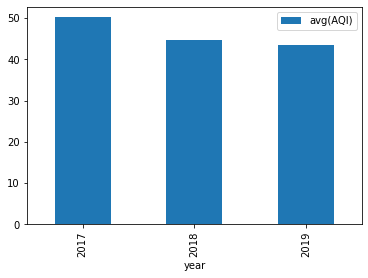

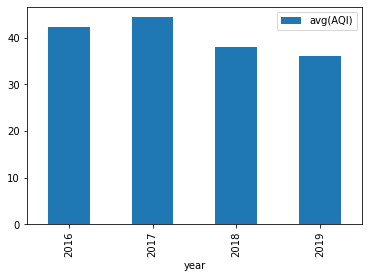

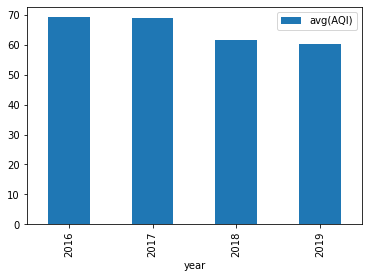

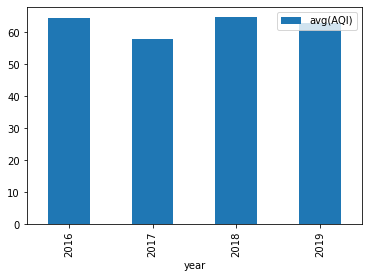

In [19]:
year_wise_Aqi_san_diego=spark.sql("""select County_Name,avg(AQI),YEAR(DATE_LOCAL) as year from df where
County_Name='San Diego' 
group by YEAR(date_local),County_Name order by YEAR(DATE_LOCAL)""")
year_wise_Aqi_san_diego = year_wise_Aqi_san_diego.toPandas()
p3=year_wise_Aqi_san_diego.plot.bar(x='year',y='avg(AQI)')
display()

year_wise_Aqi_Los_Angeles=spark.sql("""select County_Name,avg(AQI),YEAR(DATE_LOCAL) as year from df where
County_Name='Los Angeles' 
group by YEAR(date_local),County_Name order by YEAR(DATE_LOCAL)""")
year_wise_Aqi_Los_Angeles = year_wise_Aqi_Los_Angeles.toPandas()
p3=year_wise_Aqi_Los_Angeles.plot.bar(x='year',y='avg(AQI)')
display()


year_wise_Aqi_Riverside=spark.sql("""select County_Name,avg(AQI),YEAR(DATE_LOCAL) as year from df where 
County_Name='Riverside' 
group by YEAR(date_local),County_Name order by YEAR(DATE_LOCAL)""")
year_wise_Aqi_Riverside = year_wise_Aqi_Riverside.toPandas()
p3=year_wise_Aqi_Riverside.plot.bar(x='year',y='avg(AQI)')
display()

year_wise_Aqi_San_Bernardino=spark.sql("""select County_Name,avg(AQI),YEAR(DATE_LOCAL) as year from df where 
County_Name='San Bernardino' 
group by YEAR(date_local),County_Name order by YEAR(DATE_LOCAL)""")
year_wise_Aqi_San_Bernardino = year_wise_Aqi_San_Bernardino.toPandas()
p3=year_wise_Aqi_San_Bernardino.plot.bar(x='year',y='avg(AQI)')
display()

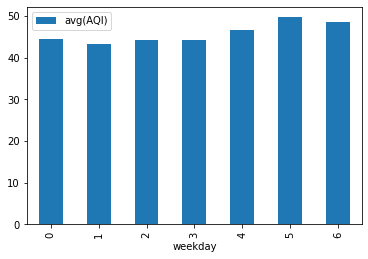

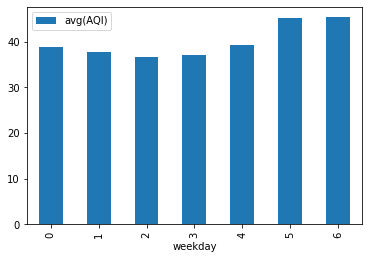

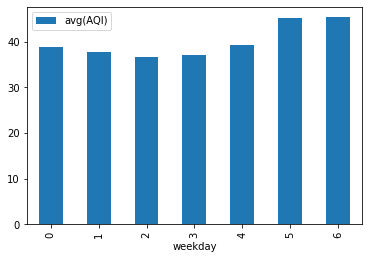

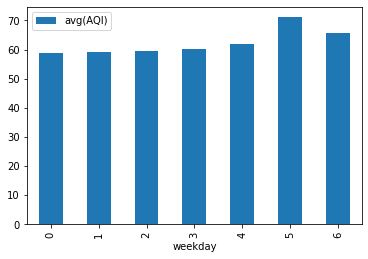

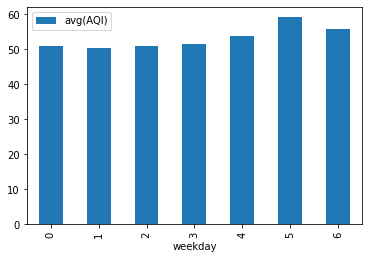

In [20]:
weekday_wise_Aqi_san_diego=spark.sql("""select avg(AQI),WEEKDAY(DATE_LOCAL) as weekday from df where County_Name='San Diego' 
group by WEEKDAY(date_local),County_Name order by WEEKDAY(DATE_LOCAL)""")
weekday_wise_Aqi_san_diego = weekday_wise_Aqi_san_diego.toPandas()
p3=weekday_wise_Aqi_san_diego.plot.bar(x='weekday',y='avg(AQI)')
display()

weekday_wise_Aqi_Los_Angeles=spark.sql("""select avg(AQI),WEEKDAY(DATE_LOCAL) as weekday from df where County_Name='Los Angeles' 
group by WEEKDAY(date_local),County_Name order by WEEKDAY(DATE_LOCAL)""")
weekday_wise_Aqi_Los_Angeles = weekday_wise_Aqi_Los_Angeles.toPandas()
p3=weekday_wise_Aqi_Los_Angeles.plot.bar(x='weekday',y='avg(AQI)')
display()

weekday_wise_Aqi_Riverside=spark.sql("""select avg(AQI),WEEKDAY(DATE_LOCAL) as weekday from df where County_Name='Riverside' 
group by WEEKDAY(date_local),County_Name order by WEEKDAY(DATE_LOCAL)""")
weekday_wise_Aqi_Riverside = weekday_wise_Aqi_Riverside.toPandas()
p3=weekday_wise_Aqi_Los_Angeles.plot.bar(x='weekday',y='avg(AQI)')
display()

weekday_wise_Aqi_San_Bernardino=spark.sql("""select avg(AQI),WEEKDAY(DATE_LOCAL) as weekday from df where County_Name='San Bernardino' 
group by WEEKDAY(date_local),County_Name order by WEEKDAY(DATE_LOCAL)""")
weekday_wise_Aqi_San_Bernardino = weekday_wise_Aqi_San_Bernardino.toPandas()
p3=weekday_wise_Aqi_San_Bernardino.plot.bar(x='weekday',y='avg(AQI)')
display()

weekday_wise_Aqi=spark.sql("""select avg(AQI),WEEKDAY(DATE_LOCAL) as weekday from df 
group by WEEKDAY(date_local) order by WEEKDAY(DATE_LOCAL)""")
weekday_wise_Aqi = weekday_wise_Aqi.toPandas()
p3=weekday_wise_Aqi.plot.bar(x='weekday',y='avg(AQI)')
display()

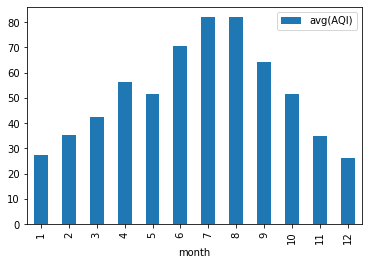

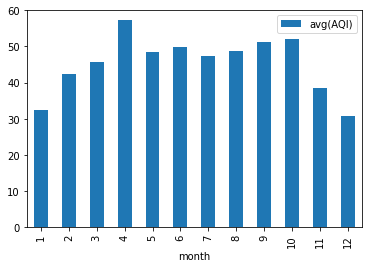

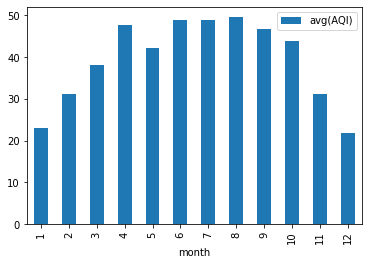

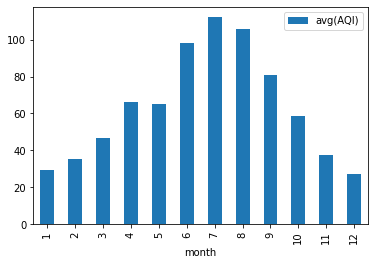

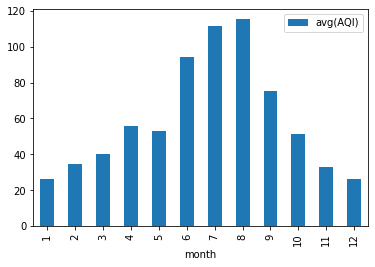

In [21]:
month_wise_Aqi=spark.sql("""select avg(AQI),MONTH(DATE_LOCAL) as month from df 
group by MONTH(date_local) order by MONTH(DATE_LOCAL)""")
month_wise_Aqi = month_wise_Aqi.toPandas()
p3=month_wise_Aqi.plot.bar(x='month',y='avg(AQI)')
display()

month_wise_Aqi_San_Diego=spark.sql("""select avg(AQI),MONTH(DATE_LOCAL) as month from df where County_Name='San Diego' 
group by MONTH(date_local),County_Name order by MONTH(DATE_LOCAL)""")
month_wise_Aqi_San_Diego = month_wise_Aqi_San_Diego.toPandas()
p3=month_wise_Aqi_San_Diego.plot.bar(x='month',y='avg(AQI)')
display()

month_wise_Aqi_Los_Angeles=spark.sql("""select avg(AQI),MONTH(DATE_LOCAL) as month from df where County_Name='Los Angeles' 
group by MONTH(date_local),County_Name order by MONTH(DATE_LOCAL)""")
month_wise_Aqi_Los_Angeles = month_wise_Aqi_Los_Angeles.toPandas()
p3=month_wise_Aqi_Los_Angeles.plot.bar(x='month',y='avg(AQI)')
display()

month_wise_Aqi_Riverside=spark.sql("""select avg(AQI),MONTH(DATE_LOCAL) as month from df where County_Name='Riverside' 
group by MONTH(date_local),County_Name order by MONTH(DATE_LOCAL)""")
month_wise_Aqi_Riverside = month_wise_Aqi_Riverside.toPandas()
p3=month_wise_Aqi_Riverside.plot.bar(x='month',y='avg(AQI)')
display()

month_wise_Aqi_San_Bernardino=spark.sql("""select avg(AQI),MONTH(DATE_LOCAL) as month from df where County_Name='San Bernardino' 
group by MONTH(date_local),County_Name order by MONTH(DATE_LOCAL)""")
month_wise_Aqi_San_Bernardino = month_wise_Aqi_San_Bernardino.toPandas()
p3=month_wise_Aqi_San_Bernardino.plot.bar(x='month',y='avg(AQI)')
display()

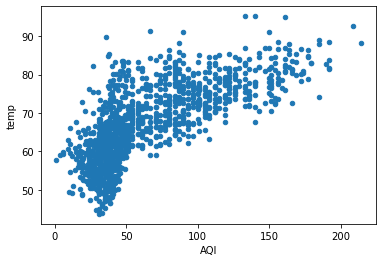

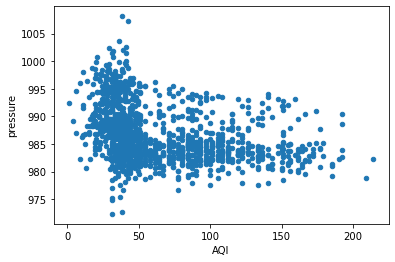

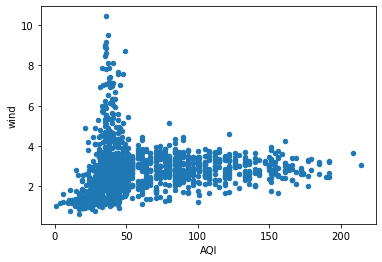

In [22]:
# AQI to demographic features
# With increase in temperature AQI increases 
temp_wise_Aqi=spark.sql("""select AQI,temp_Mean as temp from df 
where County_Name='Riverside'""")
temp_wise_Aqi = temp_wise_Aqi.toPandas()
p3=temp_wise_Aqi.plot.scatter(x='AQI',y='temp')


pressure_wise_Aqi=spark.sql("""select AQI,press_mean as pressure from df 
where County_Name='Riverside'""")
pressure_wise_Aqi = pressure_wise_Aqi.toPandas()
p3=pressure_wise_Aqi.plot.scatter(x='AQI',y='pressure')

wind_wise_Aqi=spark.sql("""select AQI,wind_mean as wind from df 
where County_Name='Riverside'""")
wind_wise_Aqi = wind_wise_Aqi.toPandas()
p3=wind_wise_Aqi.plot(x='AQI',y='wind',kind='scatter')

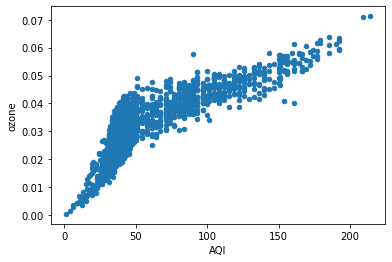

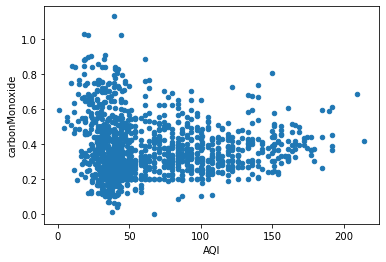

In [23]:
# AQI to pollutants
# With increase in ozone AQI increases linearly
ozone_wise_Aqi=spark.sql("""select AQI,ozone_mean as ozone from df 
where County_Name='Riverside'""")
ozone_wise_Aqi = ozone_wise_Aqi.toPandas()
p3=ozone_wise_Aqi.plot.scatter(x='AQI',y='ozone')

co_wise_Aqi=spark.sql("""select AQI,co_mean as carbonMonoxide from df 
where County_Name='Riverside'""")
co_wise_Aqi = co_wise_Aqi.toPandas()
p3=co_wise_Aqi.plot.scatter(x='AQI',y='carbonMonoxide')

In [24]:
#Descriptive Statistics
numerical = ['Latitude','Longitude','AQI', 'ozone_mean', 'ozone_1st_Max_Value', 'so2_mean', 'so2_1st_Max_Value',\
            'co_mean', 'co_1st_Max_Value', 'no2_mean', 'no2_1st_Max_Value', 'wind_mean', 'wind_1st_Max_Value',\
            'temp_mean', 'temp_1st_Max_Value', 'press_mean', 'press_1st_Max_Value']
descriptive_statistics = df.describe(numerical)

descriptive_statistics.show()

+-------+------------------+-------------------+-----------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+
|summary|          Latitude|          Longitude|              AQI|         ozone_mean| ozone_1st_Max_Value|           so2_mean| so2_1st_Max_Value|            co_mean|   co_1st_Max_Value|          no2_mean| no2_1st_Max_Value|        wind_mean|wind_1st_Max_Value|        temp_mean|temp_1st_Max_Value|        press_mean|press_1st_Max_Value|
+-------+------------------+-------------------+-----------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------

In [25]:
features_selected=['Longitude','Latitude','ozone_mean','so2_1st_Max_Value','co_mean','no2_mean',
                   'wind_1st_Max_Value','temp_mean','press_1st_Max_Value','AQI']
df_transformed = df.select(features_selected)

In [26]:
#correlations
import six
for i in df_transformed.columns:
    if not( isinstance(df_transformed.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to AQI for ", i, df_transformed.stat.corr('AQI',i))

Correlation to AQI for  Longitude 0.13607775680902542
Correlation to AQI for  Latitude 0.10778220815325008
Correlation to AQI for  ozone_mean 0.7567372447594986
Correlation to AQI for  so2_1st_Max_Value 0.13294963420636752
Correlation to AQI for  co_mean -0.1296268618843152
Correlation to AQI for  no2_mean -0.04927381372243622
Correlation to AQI for  wind_1st_Max_Value 0.1339142940722104
Correlation to AQI for  temp_mean 0.6289504040681411
Correlation to AQI for  press_1st_Max_Value -0.37224055029686337
Correlation to AQI for  AQI 1.0


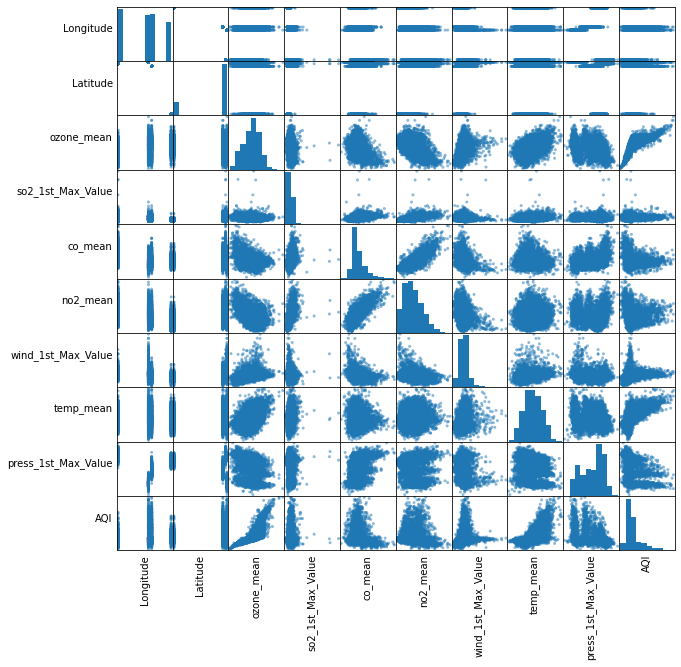

In [27]:
import pandas as pd

sampled_data = df_transformed.select(features_selected).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

<h2><center>Creating County-Wise Dataframes

In [28]:
counties = chain(*df.select("County_Name").distinct().collect())

In [29]:
df_by_county = {}

In [30]:
for county in counties:
    df_by_county[county] = df.filter(df.County_Name == county)

In [31]:
for county in df_by_county.keys():
    df_by_county[county] = df_by_county[county].select(features_selected)

In [32]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

vectorAssembler = VectorAssembler(inputCols=[i for i in features_selected if i != 'AQI'],outputCol='features')

In [33]:
random.seed(3456)
#np.random.seed(3456)

In [34]:
df_train = {}
df_test = {}
for county in df_by_county.keys():
    df_train[county], df_test[county] \
    = vectorAssembler.transform(df_by_county[county]).select(['features', 'AQI']).randomSplit([0.7,0.3])

<h2><center>Linear Regression</center></h2>

In [35]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='AQI', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [36]:
regression_models = {}
for county in df_train.keys():
    regression_models[county] = lr.fit(df_train[county])
    print(county)
    print("Coefficients: " + str(regression_models[county].coefficients))
    print("Intercept: " + str(regression_models[county].intercept))

Los Angeles
Coefficients: [0.0,0.0,1432.172358113713,-0.18743898832245495,0.0,0.6697860136339208,0.34269460149776304,0.5563518612662682,0.0]
Intercept: -49.543364563795016
San Diego
Coefficients: [0.0,0.0,1596.2584356067425,8.971483595472545,-0.0,1.0258251198383805,0.0,0.31104011364188394,0.15009014153793673]
Intercept: -190.79196549470035
Riverside
Coefficients: [0.0,0.0,2742.525978971879,-2.656657101476771,-4.372171109418765,1.1355783663759182,-2.8086456749365922,1.1040343492021423,0.13409586923682518]
Intercept: -226.64937549005035
San Bernardino
Coefficients: [0.0,0.0,2633.55404286927,4.506181891530096,-20.54567815014062,1.1346135297004554,-2.1472976023492634,1.0085219247659065,0.1640863428609917]
Intercept: -248.56184641932902


In [37]:
regression_predictions = {}
for county in df_test.keys():
    regression_predictions[county] = regression_models[county].transform(df_test[county])
    print(county)
    regression_predictions[county].select(['prediction', 'AQI']).show(5)

Los Angeles
+------------------+---+
|        prediction|AQI|
+------------------+---+
|30.441349344830947| 24|
| 60.02145866636102|108|
|30.058723993452965| 18|
|22.590382771424267| 25|
| 48.64107174249856| 47|
+------------------+---+
only showing top 5 rows

San Diego
+------------------+---+
|        prediction|AQI|
+------------------+---+
| 45.58433772697069| 40|
|  47.1051818769341| 44|
| 59.61480497359574| 50|
|20.772439567190276|  8|
|28.202600897578066| 34|
+------------------+---+
only showing top 5 rows

Riverside
+------------------+---+
|        prediction|AQI|
+------------------+---+
| 78.60852615624256| 49|
| 49.22635117815051| 36|
| 69.01949876895279| 87|
| 74.23862088124159| 64|
|55.918317533557314| 45|
+------------------+---+
only showing top 5 rows

San Bernardino
+------------------+---+
|        prediction|AQI|
+------------------+---+
|20.012577176303637| 34|
|126.25205172711503|151|
|29.545143876073382| 44|
| 41.88755851845525| 39|
| 93.67696570227685|126|
+--

In [38]:
from pyspark.ml.evaluation import RegressionEvaluator

In [39]:
r2_eval = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="AQI",metricName="r2")
RMSE_eval = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="AQI",metricName="rmse")

In [40]:
linear_regression_r2_dict = {}
linear_regression_RMSE_dict = {}
for county in df_test.keys():
    print(county)
    linear_regression_r2_dict[county] = r2_eval.evaluate(regression_predictions[county])
    linear_regression_RMSE_dict[county] = RMSE_eval.evaluate(regression_predictions[county])
    print("R Squared (R2) on test data = %g" % linear_regression_r2_dict[county])
    print("Root Mean Square Error(RMSE) on test data= %g" % linear_regression_RMSE_dict[county])

Los Angeles
R Squared (R2) on test data = 0.717467
Root Mean Square Error(RMSE) on test data= 8.75887
San Diego
R Squared (R2) on test data = 0.768237
Root Mean Square Error(RMSE) on test data= 7.05605
Riverside
R Squared (R2) on test data = 0.84553
Root Mean Square Error(RMSE) on test data= 15.337
San Bernardino
R Squared (R2) on test data = 0.855982
Root Mean Square Error(RMSE) on test data= 15.9183


In [41]:
x = linear_regression_r2_dict.values()
y = linear_regression_RMSE_dict.values()
print('Average R Squared:',sum(x)/len(x))
print('Average RMSE:',sum(y)/len(y))

Average R Squared: 0.79680391975356
Average RMSE: 11.76756212539085


<h2><center>Decision Tree</center></h2>

In [42]:
#DecisionTreeRegression
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'AQI')

In [43]:
dt_models = {}
for county in df_train.keys():
    dt_models[county] = dt.fit(df_train[county])

In [44]:
dt_predictions = {}
for county in df_test.keys():
    dt_predictions[county] = dt_models[county].transform(df_test[county])
    print(county)
    dt_predictions[county].select(['prediction', 'AQI']).show(5)

Los Angeles
+------------------+---+
|        prediction|AQI|
+------------------+---+
| 29.53846153846154| 24|
|          59.65625|108|
| 18.49019607843137| 18|
|22.166666666666668| 25|
|48.142857142857146| 47|
+------------------+---+
only showing top 5 rows

San Diego
+------------------+---+
|        prediction|AQI|
+------------------+---+
| 45.30769230769231| 40|
| 45.30769230769231| 44|
|              48.5| 50|
|14.333333333333334|  8|
|32.246753246753244| 34|
+------------------+---+
only showing top 5 rows

Riverside
+------------------+---+
|        prediction|AQI|
+------------------+---+
| 41.41935483870968| 49|
| 41.16346153846154| 36|
|  78.0909090909091| 87|
|  71.1470588235294| 64|
|38.526315789473685| 45|
+------------------+---+
only showing top 5 rows

San Bernardino
+------------------+---+
|        prediction|AQI|
+------------------+---+
| 31.25925925925926| 34|
| 149.8421052631579|151|
|45.345454545454544| 44|
| 40.51063829787234| 39|
| 79.34920634920636|126|
+--

In [45]:
dt_r2_dict = {}
dt_RMSE_dict = {}
for county in df_test.keys():
    print(county)
    dt_r2_dict[county] = r2_eval.evaluate(dt_predictions[county])
    dt_RMSE_dict[county] = RMSE_eval.evaluate(dt_predictions[county])
    print("R Squared (R2) on test data = %g" % dt_r2_dict[county])
    print("Root Mean Square Error(RMSE) on test data= %g" % dt_RMSE_dict[county])

Los Angeles
R Squared (R2) on test data = 0.688927
Root Mean Square Error(RMSE) on test data= 9.19062
San Diego
R Squared (R2) on test data = 0.745473
Root Mean Square Error(RMSE) on test data= 7.39446
Riverside
R Squared (R2) on test data = 0.8811
Root Mean Square Error(RMSE) on test data= 13.4557
San Bernardino
R Squared (R2) on test data = 0.902823
Root Mean Square Error(RMSE) on test data= 13.0759


In [46]:
x = dt_r2_dict.values()
y = dt_RMSE_dict.values()
print('Average R Squared:',sum(x)/len(x))
print('Average RMSE:',sum(y)/len(y))

Average R Squared: 0.8045807305870389
Average RMSE: 10.779183533781339


<h2><center>GBT</center></h2>

In [47]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'AQI', maxIter=10)

In [48]:
gbt_models = {}
for county in df_train.keys():
    gbt_models[county] = gbt.fit(df_train[county])

In [49]:
gbt_predictions = {}
for county in df_test.keys():
    gbt_predictions[county] = gbt_models[county].transform(df_test[county])
    print(county)
    gbt_predictions[county].select(['prediction', 'AQI']).show(5)

Los Angeles
+------------------+---+
|        prediction|AQI|
+------------------+---+
|26.617308418015774| 24|
| 64.35089698846426|108|
|18.944510460780695| 18|
|22.226653105747882| 25|
| 48.26016288456133| 47|
+------------------+---+
only showing top 5 rows

San Diego
+------------------+---+
|        prediction|AQI|
+------------------+---+
| 44.39918887207568| 40|
|43.776754036060794| 44|
| 46.97635043832675| 50|
|15.151347139515916|  8|
| 32.87185588379196| 34|
+------------------+---+
only showing top 5 rows

Riverside
+------------------+---+
|        prediction|AQI|
+------------------+---+
|45.548221551818756| 49|
|40.613915596614994| 36|
| 72.32246547508029| 87|
| 69.55499991357148| 64|
|36.711948520534335| 45|
+------------------+---+
only showing top 5 rows

San Bernardino
+------------------+---+
|        prediction|AQI|
+------------------+---+
| 31.21293300233968| 34|
|148.77898389173063|151|
| 43.70410668599544| 44|
|39.104462336819154| 39|
| 90.62499229371717|126|
+--

In [50]:
gbt_r2_dict = {}
gbt_RMSE_dict = {}
for county in df_test.keys():
    print(county)
    gbt_r2_dict[county] = r2_eval.evaluate(gbt_predictions[county])
    gbt_RMSE_dict[county] = RMSE_eval.evaluate(gbt_predictions[county])
    print("R Squared (R2) on test data = %g" % gbt_r2_dict[county])
    print("Root Mean Square Error(RMSE) on test data= %g" % gbt_RMSE_dict[county])

Los Angeles
R Squared (R2) on test data = 0.713552
Root Mean Square Error(RMSE) on test data= 8.81935
San Diego
R Squared (R2) on test data = 0.77972
Root Mean Square Error(RMSE) on test data= 6.87902
Riverside
R Squared (R2) on test data = 0.89347
Root Mean Square Error(RMSE) on test data= 12.7366
San Bernardino
R Squared (R2) on test data = 0.915814
Root Mean Square Error(RMSE) on test data= 12.1705


In [51]:
x = gbt_r2_dict.values()
y = gbt_RMSE_dict.values()
print('Average R Squared:',sum(x)/len(x))
print('Average RMSE:',sum(y)/len(y))

Average R Squared: 0.8256390779567446
Average RMSE: 10.15137402327745
